<a href="https://colab.research.google.com/github/prakharrustagi42/Prakhar_INFO5731_Fall2025/blob/main/Rustagi_Prakhar_Assignment_04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **INFO5731 Assignment: 4**

**This exercise will provide a valuable learning experience in working with text data and extracting features using various topic modeling algorithms. Key concepts such as Latent Dirichlet Allocation (LDA), Latent Semantic Analysis (LSA) and BERTopic.**



**Expectations**:

*   Use the provided .*ipynb* document to write your code & respond to the questions. Avoid generating a new file.
*   Write complete answers and run all the cells before submission.
*   Make sure the submission is "clean"; *i.e.*, no unnecessary code cells.
*   Once finished, allow shared rights from top right corner (*see Canvas for details*).

**Total points**: 100


NOTE: The output should be presented well to get **full points**

**Late submissions will have a penalty of 10% of the marks for each day of late submission, and no requests will be answered. Manage your time accordingly.**


# **Question 1 (20 Points)**

**Dataset**: 20 Newsgroups dataset

**Dataset Link**: https://scikit-learn.org/0.19/datasets/twenty_newsgroups.html

**Consider Random 2000 rows only**

Generate K=10 topics by using LDA and LSA,
then calculate coherence score and determine the optimized K value by the coherence score. Further, summarize and visualize each topics in you own words.


In [2]:
# install genism and h5py
!pip install gensim
!pip install --upgrade h5py

# import libraries

from sklearn.datasets import fetch_20newsgroups
import pandas as pd
import numpy as np
import re
import nltk
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim import corpora
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim.models import CoherenceModel
from gensim.models.ldamodel import LdaModel
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

# fetch the dataset
newsgroups_train = fetch_20newsgroups(subset='train', shuffle = True, remove=('headers', 'footers', 'qutes'))
df = pd.DataFrame({'News': newsgroups_train.data, 'Target': newsgroups_train.target})

# select 2000 rows from dataset
df = df.head(2000)
df.shape


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 29.9 MB/s eta 0:00:00


(2000, 2)

In [3]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

# Clean and tokenize text
def preprocess(text):
    text = re.sub(r'\W+', ' ', str(text).lower())
    tokens = word_tokenize(text)
    return [t for t in tokens if t not in stopwords.words('english') and len(t) > 2]

# Apply preprocessing
processed_docs = df['News'].apply(preprocess).tolist()

# Dictionary and corpus for LDA
dictionary = corpora.Dictionary(processed_docs)
corpus = [dictionary.doc2bow(text) for text in processed_docs]

# TF-IDF and Count matrix
tfidf_vectorizer = TfidfVectorizer(tokenizer=lambda x: x, lowercase=False)
count_vectorizer = CountVectorizer(tokenizer=lambda x: x, lowercase=False)

tfidf_matrix = tfidf_vectorizer.fit_transform(processed_docs)
count_matrix = count_vectorizer.fit_transform(processed_docs)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [4]:
# function to train both LSA and LDA model based on input
def compute_coherence(texts, dictionary, model_type='lda', k=10):
    if model_type == 'lda':
        model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=k, random_state=42, passes=10)
        cm = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
    else:  # LSA
        model = TruncatedSVD(n_components=k, random_state=42)
        model.fit(tfidf_matrix)
        topics = [
            [tfidf_vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-10 - 1:-1]]
            for topic in model.components_
        ]
        cm = CoherenceModel(topics=topics, texts=texts, dictionary=dictionary, coherence='c_v')
    return model, cm.get_coherence()

# Generate LDA and LSA for K=10
lda_model, lda_score = compute_coherence(processed_docs, dictionary, model_type='lda', k=10)
lsa_model, lsa_score = compute_coherence(processed_docs, dictionary, model_type='lsa', k=10)

# coherence score at K=10
print(f"LDA Coherence Score (K=10): {lda_score}")
print(f"LSA Coherence Score (K=10): {lsa_score}")

LDA Coherence Score (K=10): 0.485858642763497
LSA Coherence Score (K=10): 0.5023300530172993


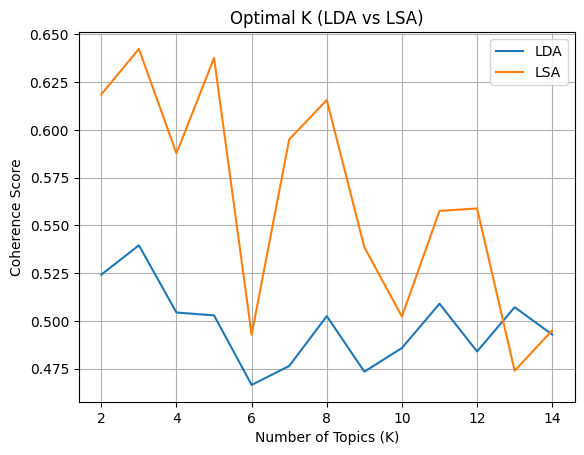

Best K for LDA: 3, Score: 0.5395926218301488
Best K for LSA: 3, Score: 0.6423956369468516


In [5]:
# plotting coherence vs topic graph for each k value
def get_best_k(model_type='lda', start=2, limit=15, step=1):
    scores = []
    for k in range(start, limit, step):
        _, score = compute_coherence(processed_docs, dictionary, model_type=model_type, k=k)
        scores.append(score)
    return list(range(start, limit, step)), scores

ks, lda_scores = get_best_k('lda')
_, lsa_scores = get_best_k('lsa')

# Plot
plt.plot(ks, lda_scores, label='LDA')
plt.plot(ks, lsa_scores, label='LSA')
plt.xlabel('Number of Topics (K)')
plt.ylabel('Coherence Score')
plt.title('Optimal K (LDA vs LSA)')
plt.legend()
plt.grid(True)
plt.show()

# printing the best k value and coherence
print(f"Best K for LDA: {ks[np.argmax(lda_scores)]}, Score: {max(lda_scores)}")
print(f"Best K for LSA: {ks[np.argmax(lsa_scores)]}, Score: {max(lsa_scores)}")

In [6]:
# function to train both LSA and LDA model for K=3 as K=3 has the highest coherence
def compute_coherence(texts, dictionary, model_type='lda', k=10):
    if model_type == 'lda':
        model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=k, random_state=42, passes=10)
        cm = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
    else:  # LSA
        model = TruncatedSVD(n_components=k, random_state=42)
        model.fit(tfidf_matrix)
        topics = [
            [tfidf_vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-10 - 1:-1]]
            for topic in model.components_
        ]
        cm = CoherenceModel(topics=topics, texts=texts, dictionary=dictionary, coherence='c_v')
    return model, cm.get_coherence()

# Generate LDA and LSA for K=3
lda_model, lda_score = compute_coherence(processed_docs, dictionary, model_type='lda', k=3)
lsa_model, lsa_score = compute_coherence(processed_docs, dictionary, model_type='lsa', k=3)

In [7]:
# installing pyLDAvis
!pip install pyLDAvis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 25.0 MB/s eta 0:00:00


In [8]:
# Import pyLDAvis for topic model visualization

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
# Enable Notebook Visualizations
pyLDAvis.enable_notebook()

# Preparing the Visualization
LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)

# Displaying the Visualization
pyLDAvis.display(LDAvis_prepared)

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


LDA has divide the dataset of 2000 rows into 3 major categories/topics.
Topic 1: It might be related to bible as it contains words such as article, jesus, book, people and god.

Topic 2: It might be related to computers or websites as it contians words such as windows, com and system.

Topic 3: It might be related to computerss but more towards harware/sotware side as it contains words such as people, space and system.

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

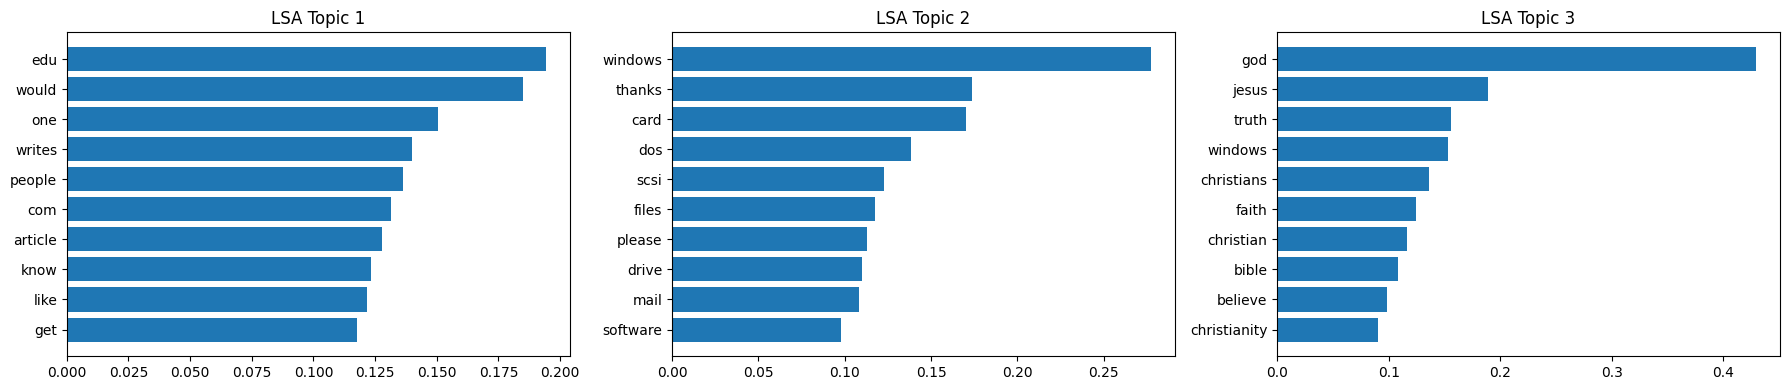

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

In [9]:
# visualizing LSA
import matplotlib.pyplot as plt

terms = tfidf_vectorizer.get_feature_names_out()
num_topics = lsa_model.components_.shape[0]
num_top_words = 10

# Grid layout: 3 columns
cols = 3
rows = (num_topics + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(18, 4 * rows))
axes = axes.flatten()

for i, comp in enumerate(lsa_model.components_):
    # Get top 10 terms and weights
    top_indices = comp.argsort()[-num_top_words:]  # Top terms (ascending indices)
    top_terms = [terms[j] for j in top_indices]
    weights = comp[top_indices]

    # Sort terms by descending weights
    sorted_pairs = sorted(zip(top_terms, weights), key=lambda x: x[1], reverse=True)
    sorted_terms, sorted_weights = zip(*sorted_pairs)

    ax = axes[i]
    ax.barh(sorted_terms, sorted_weights)
    ax.set_title(f"LSA Topic {i + 1}")
    ax.invert_yaxis()  # Most important term at top

# Hide unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

LSA has divide the dataset of 2000 rows into 3 major categories/topics.
Topic 1: It is a bit vague here as it contains words such as article, people and edu.

Topic 2: It might be related to computers or websites as it contians words such as windows, mail, software and files.

Topic 3: It might be related to religion as it contains words such as christians, jesus, truth and bible.

# **BERTopic**

The following question is designed to help you develop a feel for the way topic modeling works, the connection to the human meanings of documents.

Dataset from **assignment-3** (text dataset) .

> Dont use any custom datasets.


> Dataset must have 1000+ rows, no duplicates and null values



# **Question 2 (20 Points)**



Q2) **Generate K=10 topics by using BERTopic and then find optimal K value by the coherence score. Interpret each topic and visualize with suitable style.**

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
!pip install bertopic
!pip install emoji
import pandas as pd
# import libraries
from bertopic import BERTopic
import re
import emoji
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords


In [14]:
import pandas as pd

# Assuming 'imdb_review_cleaned.csv' is in the root of 'My Drive'
# Adjust the path if your file is in a different folder.
csv_path = '/content/drive/My Drive/imdb_review_cleaned.csv'

try:
    df = pd.read_csv(csv_path)
    print(df.shape)
    display(df.head())
except FileNotFoundError:
    print(f"Error: The file '{csv_path}' was not found. Please check the path and try again.")
except Exception as e:
    print(f"An error occurred while loading the CSV: {e}")

(1000, 2)


,review,clean_review
0,Had the pleasure to watch this film in an earl...,had pleasur watch film earli screen complet bl...
1,"If you liked or loved the first one, the same ...",if like love first one appli one person i love...
2,"Dune Part 2 is an epic movie; slickly made, an...",dune part epic movi slickli made visual stun b...
3,This is the kind of movie that is impossible t...,thi kind movi imposs justic talk it kind exper...
4,"Like the first part, the second part is visual...",like first part second part visual stun though...


In [21]:
# check for null values
df.isnull().sum()

,0
review,0
clean_review,0


In [16]:
# check for duplicate values
df.duplicated().sum()

np.int64(0)

In [28]:
# data cleaning
import nltk
import emoji # Added import emoji for direct use
nltk.download('stopwords')
nltk.download('punkt') # Ensure punkt is also downloaded
nltk.download('punkt_tab') # Explicitly download punkt_tab

stop_words = set(stopwords.words("english"))

def remove_emojis(text):
    # Use the emoji library's replace_emoji function for robust emoji removal
    return emoji.replace_emoji(text, replace="")

def clean_text(x):
    x = str(x)
    x = x.lower()
    x = remove_emojis(x)  # Removing emojis using the library
    x = re.sub(r'#[A-Za-z0-9]*', ' ', x)  # Removing hashtags
    x = re.sub(r'https*://.*', ' ', x)  # Removing URLs
    x = re.sub(r'@[A-Za-z0-9]+', ' ', x)  # Removing mentions (@user)
    tokens = word_tokenize(x)
    x = ' '.join([w for w in tokens if w.lower() not in stop_words])  # Removing stopwords

    # Define punctuation characters without problematic backslashes, let re.escape handle escaping
    # Included '“', '…”', '’' based on common text and previous error context
    punct_chars = '!”#$%&()*+,-./:;<=>?@[\]^_`{|}~“”…’'
    x = re.sub(f'[{re.escape(punct_chars)}]', ' ', x)  # Using f-string with re.escape

    x = re.sub(r'\d+', ' ', x)  # Removing numbers
    x = re.sub(r'\n+', ' ', x)  # Removing new lines
    x = re.sub(r'\s{2,}', ' ', x)  # Removing extra spaces
    return x.strip()

# Apply function to DataFrame
df['clean_text'] = df['review'].apply(clean_text)
df.head()

<>:26: SyntaxWarning: invalid escape sequence '\]'
<>:26: SyntaxWarning: invalid escape sequence '\]'
/tmp/ipython-input-2017576273.py:26: SyntaxWarning: invalid escape sequence '\]'
  punct_chars = '!”#$%&()*+,-./:;<=>?@[\]^_`{|}~“”…’'
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


,review,clean_review,clean_text
0,Had the pleasure to watch this film in an earl...,had pleasur watch film earli screen complet bl...,pleasure watch film early screening completely...
1,"If you liked or loved the first one, the same ...",if like love first one appli one person i love...,liked loved first one apply one personally lov...
2,"Dune Part 2 is an epic movie; slickly made, an...",dune part epic movi slickli made visual stun b...,dune part epic movie slickly made visually stu...
3,This is the kind of movie that is impossible t...,thi kind movi imposs justic talk it kind exper...,kind movie impossible justice talking kind exp...
4,"Like the first part, the second part is visual...",like first part second part visual stun though...,like first part second part visually stunning ...


In [35]:
tweets = df.clean_text.to_list()

# Initialize BERTopic with a fixed K using HDBSCAN's min_cluster_size workaround
topic_model = BERTopic(top_n_words=10, calculate_probabilities=True, verbose=True)
topics, probs = topic_model.fit_transform(tweets)

topic_model.reduce_topics(tweets, nr_topics=11)
topic_model.get_topic_info()

2025-11-16 19:35:30,073 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

2025-11-16 19:36:25,239 - BERTopic - Embedding - Completed ✓
2025-11-16 19:36:25,239 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-11-16 19:36:27,065 - BERTopic - Dimensionality - Completed ✓
2025-11-16 19:36:27,066 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-11-16 19:36:27,121 - BERTopic - Cluster - Completed ✓
2025-11-16 19:36:27,125 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-11-16 19:36:27,252 - BERTopic - Representation - Completed ✓
2025-11-16 19:36:27,409 - BERTopic - Topic reduction - Reducing number of topics
2025-11-16 19:36:27,417 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-11-16 19:36:27,552 - BERTopic - Representation - Completed ✓
2025-11-16 19:36:27,554 - BERTopic - Topic reduction - Reduced number of topics from 12 to 11


,Topic,Count,Name,Representation,Representative_Docs
0,-1,446,-1_movie_film_nt_part,"[movie, film, nt, part, one, dune, story, like...",[one 's destiny rule people one wo n't quit ac...
1,0,187,0_movie_dune_part_one,"[movie, dune, part, one, nt, story, first, fil...",[great movies always leave feeling seeing movi...
2,1,101,1_dune_film_part_paul,"[dune, film, part, paul, two, villeneuve, one,...",[cinematic triumph exploring epic sequel dune ...
3,2,58,2_villeneuve_denis_movie_see,"[villeneuve, denis, movie, see, nt, one, film,...",[imagine lived ' s someone produced first imax...
4,3,55,3_dune_villeneuve_part_denis,"[dune, villeneuve, part, denis, film, experien...",[dune crafted visionary denis villeneuve nothi...
5,4,54,4_movie_story_nt_first,"[movie, story, nt, first, like, part, one, cha...",[love made better first one sounds effects per...
6,5,30,5_movie_imax_time_nt,"[movie, imax, time, nt, see, watch, music, blo...",[watched imax sensationel worried high expecta...
7,6,23,6_movie_nt_one_like,"[movie, nt, one, like, film, get, really, time...",[okay let 's reign 'hype train ' rating probab...
8,7,19,7_film_movie_best_one,"[film, movie, best, one, hans, time, zimmer, c...",[modern masterpiece filled incredible visuals ...
9,8,15,8_paul_movie_looking_great,"[paul, movie, looking, great, first, film, pow...",[ending really ruined film strong love relatio...


In [43]:
topic_model.visualize_barchart(n_words = 10, width = 300, height = 400)

In [33]:
!pip install gensim
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary

def calculate_coherence_score(data, min_k=2, max_k=10):
    coherence_scores = []

    for k in range(min_k, max_k + 1):
        # Train BERTopic model with K topics
        model = BERTopic(nr_topics=k)
        topics, _ = model.fit_transform(data)

        # Extract topic words
        topic_words = [ [word for word, _ in model.get_topic(topic)] for topic in model.get_topics().keys() if topic != -1 ]

        # Prepare data for Coherence Model
        tokenized_data = [doc.split() for doc in data]
        dictionary = Dictionary(tokenized_data)

        # Compute Coherence Score
        coherence_model = CoherenceModel(topics=topic_words, dictionary=dictionary, texts=tokenized_data, coherence='c_v')
        coherence_score = coherence_model.get_coherence()
        coherence_scores.append((k, coherence_score))

        print(f"K={k}, Coherence Score={coherence_score}")

    return coherence_scores

# Example usage with 'tweets' dataset
coherence_scores = calculate_coherence_score(tweets, min_k=2, max_k=10)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 7.4 MB/s eta 0:00:00
K=2, Coherence Score=0.38244027100185585
K=3, Coherence Score=0.41495165577590026
K=4, Coherence Score=0.4385793689355217
K=5, Coherence Score=0.392088623238422
K=6, Coherence Score=0.41629479847104023
K=7, Coherence Score=0.42609194407015966
K=8, Coherence Score=0.3929593082756816
K=9, Coherence Score=0.4333815324230541
K=10, Coherence Score=0.44971178106043247


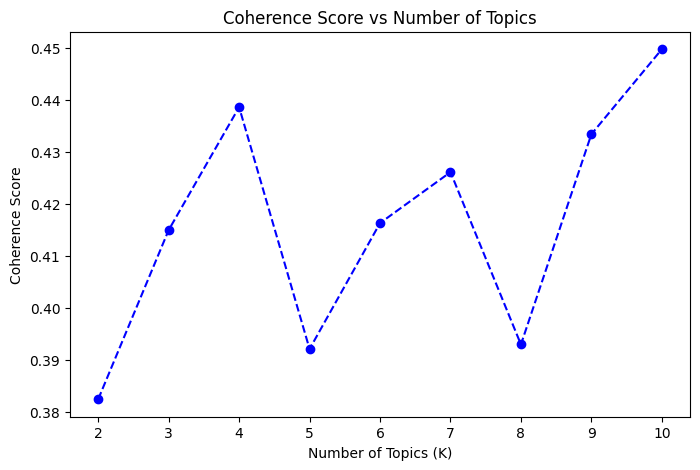

In [38]:
import matplotlib.pyplot as plt

k_values, scores = zip(*coherence_scores)

plt.figure(figsize=(8,5))
plt.plot(k_values, scores, marker='o', linestyle='dashed', color='b')
plt.xlabel("Number of Topics (K)")
plt.ylabel("Coherence Score")
plt.title("Coherence Score vs Number of Topics")
plt.show()

In [36]:
tweets = df.clean_text.to_list()

# Initialize BERTopic with a fixed K using HDBSCAN's min_cluster_size workaround
topic_model = BERTopic(top_n_words=10, calculate_probabilities=True, verbose=True)
topics, probs = topic_model.fit_transform(tweets)

topic_model.reduce_topics(tweets, nr_topics=3)
topic_model.get_topic_info()

2025-11-16 19:36:27,688 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

2025-11-16 19:37:27,183 - BERTopic - Embedding - Completed ✓
2025-11-16 19:37:27,185 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-11-16 19:37:28,987 - BERTopic - Dimensionality - Completed ✓
2025-11-16 19:37:28,988 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-11-16 19:37:29,040 - BERTopic - Cluster - Completed ✓
2025-11-16 19:37:29,044 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-11-16 19:37:29,139 - BERTopic - Representation - Completed ✓
2025-11-16 19:37:29,235 - BERTopic - Topic reduction - Reducing number of topics
2025-11-16 19:37:29,240 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-11-16 19:37:29,336 - BERTopic - Representation - Completed ✓
2025-11-16 19:37:29,338 - BERTopic - Topic reduction - Reduced number of topics from 13 to 3


,Topic,Count,Name,Representation,Representative_Docs
0,-1,397,-1_movie_film_nt_one,"[movie, film, nt, one, part, dune, story, like...",[movie meant lot cinema fans think movie beaut...
1,0,387,0_dune_part_film_movie,"[dune, part, film, movie, one, two, first, nt,...",[dune part two absolutely brilliant 's better ...
2,1,216,1_movie_nt_film_one,"[movie, nt, film, one, part, like, story, firs...",['s lot hyperbole superlatives movie since rel...


In [37]:
# Visualizing the ideal number of topics based on coherence score
topic_model.visualize_barchart(n_words = 10, width = 200, height = 300)

# **Question 3 (25 points)**


**Dataset Link**: 20 Newsgroup Dataset (Random 2000 values)

Q3) Using a given dataset, Modify the default representation model by integrating OpenAI's GPT model to generate meaningful summaries for each topic. Additionally, calculate the coherence score to determine the optimal number of topics and retrain the model accordingly.



Usefull Link: https://maartengr.github.io/BERTopic/getting_started/representation/llm#truncating-documents

**Using Sentence transformers along with 'google/gemma-2b-it' model instead of GPT. GPT is giving token limitations when we are generating summaries for 2000 sentences.**

In [39]:
# import libraries
from sklearn.datasets import fetch_20newsgroups
import pandas as pd
import numpy as np
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic
from transformers import pipeline

nltk.download('stopwords')
nltk.download('punkt_tab')
stop_words = set(stopwords.words("english"))

newsgroups_train = fetch_20newsgroups(subset='train', shuffle = True, remove=('headers', 'footers', 'qutes'))
df = pd.DataFrame({'News': newsgroups_train.data, 'Target': newsgroups_train.target})
df = df.head(2000)

def clean_text(x):
    x = str(x)
    x = x.lower()
    x = re.sub(r'#[A-Za-z0-9]*', ' ', x)  # Removing hashtags
    x = re.sub(r'https*://.*', ' ', x)  # Removing URLs
    x = re.sub(r'@[A-Za-z0-9]+', ' ', x)  # Removing mentions (@user)
    tokens = word_tokenize(x)
    x = ' '.join([w for w in tokens if w.lower() not in stop_words])  # Removing stopwords
    x = re.sub(r'[%s]' % re.escape('!"#$%&\()*+,-./:;<=>?@[\\]^_`{|}~“…”’'), ' ', x)  # Removing punctuations
    x = re.sub(r'\d+', ' ', x)  # Removing numbers
    x = re.sub(r'\n+', ' ', x)  # Removing new lines
    x = re.sub(r'\s{2,}', ' ', x)  # Removing extra spaces
    return x.strip()

# Apply function to DataFrame
df['clean_text'] = df['News'].apply(clean_text)

texts = df['clean_text'].dropna().tolist()


<>:31: SyntaxWarning:

invalid escape sequence '\('

<>:31: SyntaxWarning:

invalid escape sequence '\('

/tmp/ipython-input-2717273246.py:31: SyntaxWarning:

invalid escape sequence '\('

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [40]:
# Custom embedding model
custom_embed_model = SentenceTransformer("all-MiniLM-L6-v2")

# Embed the documents
embeddings = custom_embed_model.encode(texts, show_progress_bar=True)

# Create BERTopic with custom pipeline
custom_model = BERTopic(embedding_model=custom_embed_model)
custom_model.fit(texts, embeddings=embeddings)

Batches:   0%|          | 0/63 [00:00<?, ?it/s]

In [41]:
# getting the total number of topics
custom_model.get_topic_info().count()

,0
Topic,18
Count,18
Name,18
Representation,18
Representative_Docs,18


In [55]:
from huggingface_hub import login
login(new_session=False)

In [56]:
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline

# loading the model
model_name = "google/gemma-2b-it"

# Set pipeline to use GPU
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto", torch_dtype="auto")

summarizer = pipeline("text-generation", model=model, tokenizer=tokenizer)

tokenizer_config.json:   0%|          | 0.00/34.2k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/627 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json:   0%|          | 0.00/13.5k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/67.1M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

Device set to use cpu


In [57]:
# function to give a summary of the topic
def summarize_topic_with_llama(topic_words, topic_id):
    prompt = f"Topic {topic_id}: {', '.join(topic_words)}\nWrite a 2-sentence summary."
    response = summarizer(prompt, max_new_tokens=80, do_sample=True)[0]['generated_text']
    return response.strip()

In [58]:
llama_summaries = {}

# loop to give summary of each topic
for topic_id in custom_model.get_topics().keys():
    if topic_id == -1:
        continue
    topic_words = [word for word, _ in custom_model.get_topic(topic_id)[:10]]
    llama_summaries[topic_id] = summarize_topic_with_llama(topic_words, topic_id)

# Print summaries
for tid, summary in llama_summaries.items():
    print(f"\n Topic {tid}: {summary}")


 Topic 0: Topic 0: edu, windows, file, dos, use, com, program, output, get, scsi
Write a 2-sentence summary.

Edu, Windows, File, DOS, Use, Com, Program, Output, Get, SCSI are all related to computer technology.

 Topic 1: Topic 1: car, article, com, writes, bike, cars, edu, engine, one, would
Write a 2-sentence summary.

Sure, here's the summary you requested:

Car, article, com, writes, bike, cars, edu, engine, one, would. These are all related to the topic of cars.

 Topic 2: Topic 2: god, jesus, one, people, christian, truth, bible, argument, christians, believe
Write a 2-sentence summary.

Sure, here's a 2-sentence summary of the topic you requested:

God, Jesus, one, people, Christian, truth, Bible, argument, Christians, believe are all related to the concept of belief in a supernatural being or entity.

 Topic 3: Topic 3: year, team, baseball, better, last, runs, edu, games, braves, hit
Write a 2-sentence summary.

This topic focuses on terms related to baseball. It emphasizes 

In [59]:
# calculating coherence score for base bert model
def calculate_coherence_score(data, min_k=2, max_k=20):
    coherence_scores = []

    for k in range(min_k, max_k + 1):
        # Train BERTopic model with K topics
        model = BERTopic(embedding_model=custom_embed_model)
        topics, _ = model.fit_transform(data, embeddings=embeddings)

        # Extract topic words
        topic_words = [ [word for word, _ in model.get_topic(topic)] for topic in model.get_topics().keys() if topic != -1 ]

        # Prepare data for Coherence Model
        tokenized_data = [doc.split() for doc in data]
        dictionary = Dictionary(tokenized_data)

        # Compute Coherence Score
        coherence_model = CoherenceModel(topics=topic_words, dictionary=dictionary, texts=tokenized_data, coherence='c_v')
        coherence_score = coherence_model.get_coherence()
        coherence_scores.append((k, coherence_score))

        print(f"K={k}, Coherence Score={coherence_score}")

    return coherence_scores

# getting coherence score to get optimal number of topics
coherence_scores = calculate_coherence_score(texts, min_k=2, max_k=20)

K=2, Coherence Score=0.638233996688236
K=3, Coherence Score=0.6259954347433596
K=4, Coherence Score=0.6425864499504973
K=5, Coherence Score=0.6367016638401993
K=6, Coherence Score=0.651593263715671
K=7, Coherence Score=0.6237288094452436
K=8, Coherence Score=0.6758910307055453
K=9, Coherence Score=0.6393571729115469
K=10, Coherence Score=0.6388030651200856
K=11, Coherence Score=0.6385374282302665
K=12, Coherence Score=0.6259343959672176
K=13, Coherence Score=0.6290870157078178
K=14, Coherence Score=0.6330912753090848
K=15, Coherence Score=0.6880796984339534
K=16, Coherence Score=0.6187625425435715
K=17, Coherence Score=0.6478528275305397
K=18, Coherence Score=0.6484426555032088
K=19, Coherence Score=0.6467931979680105
K=20, Coherence Score=0.6595830291934278


In [60]:
# Coherence for K=16 is highest
# now lets retrain the model to fit into 5 topics and summarize it again.

custom_model.reduce_topics(texts, nr_topics=16)

In [61]:
# getting summaries for newly trained model
llama_summaries = {}

# loop to give summary of each topic
for topic_id in custom_model.get_topics().keys():
    if topic_id == -1:
        continue
    topic_words = [word for word, _ in custom_model.get_topic(topic_id)[:10]]
    llama_summaries[topic_id] = summarize_topic_with_llama(topic_words, topic_id)

# Print summaries
for tid, summary in llama_summaries.items():
    print(f"\n Topic {tid}: {summary}")


 Topic 0: Topic 0: edu, windows, file, dos, use, com, program, get, output, scsi
Write a 2-sentence summary.

Sure, here is a 2-sentence summary:

Edu, Windows, files, DOS, and other computer software are used to complete tasks and projects. These tools and technologies are essential for education and scientific research.

 Topic 1: Topic 1: team, game, play, year, players, season, games, edu, last, writes
Write a 2-sentence summary.

Sure, here is a 2-sentence summary:

Team, game, play, year, players, season, games, edu, last, writes are all terms related to a specific sport or activity.

 Topic 2: Topic 2: car, article, writes, com, bike, cars, edu, engine, one, would
Write a 2-sentence summary.

Sure, here is a 2-sentence summary:

Car is a vehicle that is powered by an engine and used for transportation. Bike is a two-wheeled vehicle that is powered by human effort and used for transportation.

 Topic 3: Topic 3: god, jesus, one, people, christian, truth, argument, bible, christi

# **Question 4 (35 Points)**


**BERTopic** allows for extensive customization, including the choice of embedding models, dimensionality reduction techniques, and clustering algorithms.

**Dataset Link**: 20 Newsgroup Dataset (Random 2000 values)

4)

4.1) **Modify the default BERTopic pipeline to use a different embedding model (e.g., Sentence-Transformers) and a different clustering algorithm (e.g., DBSCAN instead of HDBSCAN).

4.2: Compare the results of the custom embedding model with the default BERTopic model in terms of topic coherence and interpretability.

4.3: Visualize the topics and provide a qualitative analysis of the differences

**

Usefull Link :https://www.pinecone.io/learn/bertopic/

In [62]:
# import libraries
from sklearn.datasets import fetch_20newsgroups
import pandas as pd
import numpy as np
import re
import emoji
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from bertopic import BERTopic
from bertopic.backend import BaseEmbedder
from sklearn.cluster import DBSCAN
from sentence_transformers import SentenceTransformer
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary

# fetching the dataset and select 2000 random rows
newsgroups_train = fetch_20newsgroups(subset='train', shuffle = True, remove=('headers', 'footers', 'qutes'))
df = pd.DataFrame({'News': newsgroups_train.data, 'Target': newsgroups_train.target})
df = df.head(2000)

In [63]:
# data cleaning process
nltk.download('stopwords')
nltk.download('punkt_tab')
stop_words = set(stopwords.words("english"))


def remove_emojis(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # Emoticons
                           u"\U0001F300-\U0001F5FF"  # Symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # Transport & map symbols
                           u"\U0001F700-\U0001F77F"  # Alchemical symbols
                           u"\U0001F780-\U0001F7FF"  # Geometric shapes
                           u"\U0001F800-\U0001F8FF"  # Supplemental arrows
                           u"\U0001F900-\U0001F9FF"  # Supplemental symbols
                           u"\U0001FA00-\U0001FA6F"  # Chess pieces, symbols
                           u"\U0001FA70-\U0001FAFF"  # Other pictographs
                           u"\U00002702-\U000027B0"  # Dingbats
                           u"\U000024C2-\U0001F251"  # Enclosed characters
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def clean_text(x):
    x = str(x)
    x = x.lower()
    x = remove_emojis(x)  # Removing emojis
    x = re.sub(r'#[A-Za-z0-9]*', ' ', x)  # Removing hashtags
    x = re.sub(r'https*://.*', ' ', x)  # Removing URLs
    x = re.sub(r'@[A-Za-z0-9]+', ' ', x)  # Removing mentions (@user)
    tokens = word_tokenize(x)
    x = ' '.join([w for w in tokens if w.lower() not in stop_words])  # Removing stopwords
    x = re.sub(r'[%s]' % re.escape('!"#$%&\()*+,-./:;<=>?@[\\]^_`{|}~“…”’'), ' ', x)  # Removing punctuations
    x = re.sub(r'\d+', ' ', x)  # Removing numbers
    x = re.sub(r'\n+', ' ', x)  # Removing new lines
    x = re.sub(r'\s{2,}', ' ', x)  # Removing extra spaces
    return x.strip()

# Apply function to DataFrame
df['clean_text'] = df['News'].apply(clean_text)
df.head()

<>:32: SyntaxWarning:

invalid escape sequence '\('

<>:32: SyntaxWarning:

invalid escape sequence '\('

/tmp/ipython-input-2665558160.py:32: SyntaxWarning:

invalid escape sequence '\('

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


,News,Target,clean_text
0,I was wondering if anyone out there could enli...,7,wondering anyone could enlighten car saw day d...
1,A fair number of brave souls who upgraded thei...,4,fair number brave souls upgraded si clock osci...
2,"well folks, my mac plus finally gave up the gh...",4,well folks mac plus finally gave ghost weekend...
3,Robert J.C. Kyanko (rob@rjck.UUCP) wrote:\n> a...,1,robert j c kyanko rob uucp wrote abraxis edu w...
4,"From article <C5owCB.n3p@world.std.com>, by to...",14,article c owcb n p std com tombaker std com to...


In [64]:
# Prepare text data
texts = df['clean_text'].dropna().tolist()

# using Default BERTopic
default_model = BERTopic()
default_topics, _ = default_model.fit_transform(texts)

# Show topic summary
default_model.get_topic_info().head()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,544,-1_ax_max_edu_pl,"[ax, max, edu, pl, ww, nt, uw, writes, ei, di]",[part '' g dy dy dy dy dy dy dy fij f dy dg ok...
1,0,197,0_car_bike_nt_article,"[car, bike, nt, article, com, writes, cars, en...",[article gte com hhd gte com horace dediu writ...
2,1,151,1_god_jesus_one_people,"[god, jesus, one, people, christian, truth, bi...",[article rutgers edu gt b gatech edu boundary ...
3,2,99,2_year_team_nt_runs,"[year, team, nt, runs, better, baseball, last,...",[maynard cs laurentian ca roger maynard writes...
4,3,90,3_output_file_program_motif,"[output, file, program, motif, window, version...",[mrr cl msu edu mark riordan writes comprehens...


In [65]:
# Custom embedding model
custom_embed_model = SentenceTransformer("all-MiniLM-L6-v2")

# Embed the documents
embeddings = custom_embed_model.encode(texts, show_progress_bar=True)

# Cluster using DBSCAN
dbscan_model = DBSCAN(eps=0.5, min_samples=5)
clusters = dbscan_model.fit_predict(embeddings)

# Create BERTopic with custom pipeline
custom_model = BERTopic(embedding_model=custom_embed_model, verbose=True)
custom_model.fit(texts, embeddings=embeddings, y=clusters)

# Show topic summary
custom_model.get_topic_info().head()

Batches:   0%|          | 0/63 [00:00<?, ?it/s]

2025-11-16 20:27:03,990 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-11-16 20:27:11,539 - BERTopic - Dimensionality - Completed ✓
2025-11-16 20:27:11,541 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-11-16 20:27:11,615 - BERTopic - Cluster - Completed ✓
2025-11-16 20:27:11,619 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-11-16 20:27:12,152 - BERTopic - Representation - Completed ✓


,Topic,Count,Name,Representation,Representative_Docs
0,-1,515,-1_ax_max_pl_ww,"[ax, max, pl, ww, uw, tm, ei, di, edu, cx]",[part m cxt m x x cbn c e x x cx x rbn hkc goc...
1,0,188,0_car_bike_article_com,"[car, bike, article, com, writes, cars, engine...",[article gte com hhd gte com horace dediu writ...
2,1,148,1_god_jesus_people_one,"[god, jesus, people, one, christian, truth, bi...",[article rutgers edu gt b gatech edu boundary ...
3,2,109,2_key_government_encryption_clipper,"[key, government, encryption, clipper, chip, w...",[article qpg finn nmsu edu amolitor edu andrew...
4,3,101,3_game_play_hockey_team,"[game, play, hockey, team, season, players, pe...",[philadelphia buffalo first period philadelphi...


In [66]:
# calculating coherence score for base bert model
def calculate_coherence_score(data, min_k=2, max_k=20):
    coherence_scores = []

    for k in range(min_k, max_k + 1):
        # Train BERTopic model with K topics
        model = BERTopic(nr_topics=k)
        topics, _ = model.fit_transform(data)

        # Extract topic words
        topic_words = [ [word for word, _ in model.get_topic(topic)] for topic in model.get_topics().keys() if topic != -1 ]

        # Prepare data for Coherence Model
        tokenized_data = [doc.split() for doc in data]
        dictionary = Dictionary(tokenized_data)

        # Compute Coherence Score
        coherence_model = CoherenceModel(topics=topic_words, dictionary=dictionary, texts=tokenized_data, coherence='c_v')
        coherence_score = coherence_model.get_coherence()
        coherence_scores.append((k, coherence_score))

        print(f"K={k}, Coherence Score={coherence_score}")

    return coherence_scores

# calculate coherence score for all type of topic distributions
coherence_scores = calculate_coherence_score(texts, min_k=2, max_k=20)

K=2, Coherence Score=0.6033187816534522
K=3, Coherence Score=0.605596387030797
K=4, Coherence Score=0.5022255825063259
K=5, Coherence Score=0.5294877378968769
K=6, Coherence Score=0.4865995448696352
K=7, Coherence Score=0.4844885080362022
K=8, Coherence Score=0.48982516946995813
K=9, Coherence Score=0.4892498410791748
K=10, Coherence Score=0.4923474004217666
K=11, Coherence Score=0.5333372006358557
K=12, Coherence Score=0.5330064209390354
K=13, Coherence Score=0.5462912711969268
K=14, Coherence Score=0.5698636733266437
K=15, Coherence Score=0.555632316729173
K=16, Coherence Score=0.5594385457046304
K=17, Coherence Score=0.5935520873799562
K=18, Coherence Score=0.573667943786284
K=19, Coherence Score=0.6021541810753556
K=20, Coherence Score=0.5650685589150073


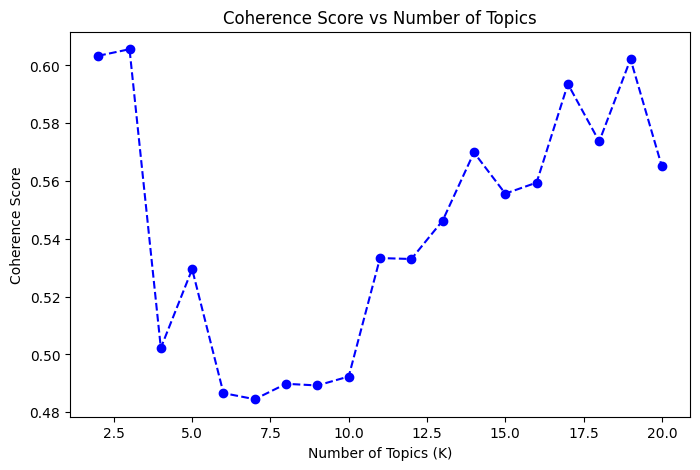

In [67]:
# plotting graph to find optimal k value for base bert model
k_values, scores = zip(*coherence_scores)

plt.figure(figsize=(8,5))
plt.plot(k_values, scores, marker='o', linestyle='dashed', color='b')
plt.xlabel("Number of Topics (K)")
plt.ylabel("Coherence Score")
plt.title("Coherence Score vs Number of Topics")
plt.show()

In [68]:
# calculating coherence score for base bert model
def calculate_coherence_score(data, min_k=2, max_k=20):
    coherence_scores = []

    for k in range(min_k, max_k + 1):
        # Train BERTopic model with K topics
        model = BERTopic(embedding_model=custom_embed_model, verbose=True)
        topics, _ = model.fit_transform(data, embeddings=embeddings, y=clusters)

        # Extract topic words
        topic_words = [ [word for word, _ in model.get_topic(topic)] for topic in model.get_topics().keys() if topic != -1 ]

        # Prepare data for Coherence Model
        tokenized_data = [doc.split() for doc in data]
        dictionary = Dictionary(tokenized_data)

        # Compute Coherence Score
        coherence_model = CoherenceModel(topics=topic_words, dictionary=dictionary, texts=tokenized_data, coherence='c_v')
        coherence_score = coherence_model.get_coherence()
        coherence_scores.append((k, coherence_score))

        print(f"K={k}, Coherence Score={coherence_score}")

    return coherence_scores

# calculating coherence score
coherence_scores = calculate_coherence_score(texts, min_k=2, max_k=20)

2025-11-16 21:06:18,739 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-11-16 21:06:24,746 - BERTopic - Dimensionality - Completed ✓
2025-11-16 21:06:24,748 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-11-16 21:06:24,799 - BERTopic - Cluster - Completed ✓
2025-11-16 21:06:24,804 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-11-16 21:06:25,149 - BERTopic - Representation - Completed ✓
2025-11-16 21:06:27,809 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


K=2, Coherence Score=0.6567416233158915


2025-11-16 21:06:34,636 - BERTopic - Dimensionality - Completed ✓
2025-11-16 21:06:34,638 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-11-16 21:06:34,719 - BERTopic - Cluster - Completed ✓
2025-11-16 21:06:34,724 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-11-16 21:06:35,267 - BERTopic - Representation - Completed ✓
2025-11-16 21:06:38,410 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


K=3, Coherence Score=0.6463025354452651


2025-11-16 21:06:45,511 - BERTopic - Dimensionality - Completed ✓
2025-11-16 21:06:45,512 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-11-16 21:06:45,563 - BERTopic - Cluster - Completed ✓
2025-11-16 21:06:45,568 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-11-16 21:06:46,057 - BERTopic - Representation - Completed ✓
2025-11-16 21:06:48,681 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


K=4, Coherence Score=0.6670847549535331


2025-11-16 21:06:55,814 - BERTopic - Dimensionality - Completed ✓
2025-11-16 21:06:55,816 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-11-16 21:06:55,868 - BERTopic - Cluster - Completed ✓
2025-11-16 21:06:55,872 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-11-16 21:06:56,295 - BERTopic - Representation - Completed ✓
2025-11-16 21:06:59,057 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


K=5, Coherence Score=0.6476467267289416


2025-11-16 21:07:05,847 - BERTopic - Dimensionality - Completed ✓
2025-11-16 21:07:05,848 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-11-16 21:07:05,933 - BERTopic - Cluster - Completed ✓
2025-11-16 21:07:05,938 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-11-16 21:07:06,539 - BERTopic - Representation - Completed ✓
2025-11-16 21:07:09,482 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


K=6, Coherence Score=0.6640925972493722


2025-11-16 21:07:15,538 - BERTopic - Dimensionality - Completed ✓
2025-11-16 21:07:15,540 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-11-16 21:07:15,591 - BERTopic - Cluster - Completed ✓
2025-11-16 21:07:15,596 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-11-16 21:07:15,985 - BERTopic - Representation - Completed ✓
2025-11-16 21:07:19,787 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


K=7, Coherence Score=0.6848808053759204


2025-11-16 21:07:25,996 - BERTopic - Dimensionality - Completed ✓
2025-11-16 21:07:25,997 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-11-16 21:07:26,049 - BERTopic - Cluster - Completed ✓
2025-11-16 21:07:26,053 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-11-16 21:07:26,592 - BERTopic - Representation - Completed ✓
2025-11-16 21:07:30,181 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


K=8, Coherence Score=0.6470274457776479


2025-11-16 21:07:36,389 - BERTopic - Dimensionality - Completed ✓
2025-11-16 21:07:36,390 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-11-16 21:07:36,442 - BERTopic - Cluster - Completed ✓
2025-11-16 21:07:36,446 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-11-16 21:07:36,895 - BERTopic - Representation - Completed ✓
2025-11-16 21:07:39,738 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


K=9, Coherence Score=0.6542839539104424


2025-11-16 21:07:46,496 - BERTopic - Dimensionality - Completed ✓
2025-11-16 21:07:46,497 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-11-16 21:07:46,547 - BERTopic - Cluster - Completed ✓
2025-11-16 21:07:46,551 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-11-16 21:07:47,067 - BERTopic - Representation - Completed ✓
2025-11-16 21:07:49,960 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


K=10, Coherence Score=0.6642891167556544


2025-11-16 21:07:56,822 - BERTopic - Dimensionality - Completed ✓
2025-11-16 21:07:56,823 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-11-16 21:07:56,875 - BERTopic - Cluster - Completed ✓
2025-11-16 21:07:56,879 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-11-16 21:07:57,242 - BERTopic - Representation - Completed ✓
2025-11-16 21:08:00,343 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


K=11, Coherence Score=0.6619436825302194


2025-11-16 21:08:07,724 - BERTopic - Dimensionality - Completed ✓
2025-11-16 21:08:07,725 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-11-16 21:08:07,778 - BERTopic - Cluster - Completed ✓
2025-11-16 21:08:07,782 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-11-16 21:08:08,120 - BERTopic - Representation - Completed ✓
2025-11-16 21:08:09,987 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


K=12, Coherence Score=0.6652726492157798


2025-11-16 21:08:16,052 - BERTopic - Dimensionality - Completed ✓
2025-11-16 21:08:16,055 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-11-16 21:08:16,122 - BERTopic - Cluster - Completed ✓
2025-11-16 21:08:16,130 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-11-16 21:08:16,746 - BERTopic - Representation - Completed ✓
2025-11-16 21:08:20,091 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


K=13, Coherence Score=0.6334839245242416


2025-11-16 21:08:26,032 - BERTopic - Dimensionality - Completed ✓
2025-11-16 21:08:26,033 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-11-16 21:08:26,083 - BERTopic - Cluster - Completed ✓
2025-11-16 21:08:26,087 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-11-16 21:08:26,582 - BERTopic - Representation - Completed ✓
2025-11-16 21:08:29,371 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


K=14, Coherence Score=0.685113776377195


2025-11-16 21:08:36,128 - BERTopic - Dimensionality - Completed ✓
2025-11-16 21:08:36,130 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-11-16 21:08:36,185 - BERTopic - Cluster - Completed ✓
2025-11-16 21:08:36,189 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-11-16 21:08:36,622 - BERTopic - Representation - Completed ✓
2025-11-16 21:08:38,371 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


K=15, Coherence Score=0.6652726492157798


2025-11-16 21:08:45,346 - BERTopic - Dimensionality - Completed ✓
2025-11-16 21:08:45,347 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-11-16 21:08:45,403 - BERTopic - Cluster - Completed ✓
2025-11-16 21:08:45,407 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-11-16 21:08:45,834 - BERTopic - Representation - Completed ✓
2025-11-16 21:08:48,669 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


K=16, Coherence Score=0.6616759989020212


2025-11-16 21:08:55,546 - BERTopic - Dimensionality - Completed ✓
2025-11-16 21:08:55,547 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-11-16 21:08:55,594 - BERTopic - Cluster - Completed ✓
2025-11-16 21:08:55,597 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-11-16 21:08:55,989 - BERTopic - Representation - Completed ✓
2025-11-16 21:08:58,686 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


K=17, Coherence Score=0.6544896009637001


2025-11-16 21:09:04,757 - BERTopic - Dimensionality - Completed ✓
2025-11-16 21:09:04,758 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-11-16 21:09:04,811 - BERTopic - Cluster - Completed ✓
2025-11-16 21:09:04,815 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-11-16 21:09:05,477 - BERTopic - Representation - Completed ✓
2025-11-16 21:09:08,630 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


K=18, Coherence Score=0.6466834862163108


2025-11-16 21:09:14,554 - BERTopic - Dimensionality - Completed ✓
2025-11-16 21:09:14,555 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-11-16 21:09:14,603 - BERTopic - Cluster - Completed ✓
2025-11-16 21:09:14,607 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-11-16 21:09:14,929 - BERTopic - Representation - Completed ✓
2025-11-16 21:09:16,730 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


K=19, Coherence Score=0.6652726492157798


2025-11-16 21:09:23,537 - BERTopic - Dimensionality - Completed ✓
2025-11-16 21:09:23,538 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-11-16 21:09:23,591 - BERTopic - Cluster - Completed ✓
2025-11-16 21:09:23,596 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-11-16 21:09:23,932 - BERTopic - Representation - Completed ✓


K=20, Coherence Score=0.6652726492157798


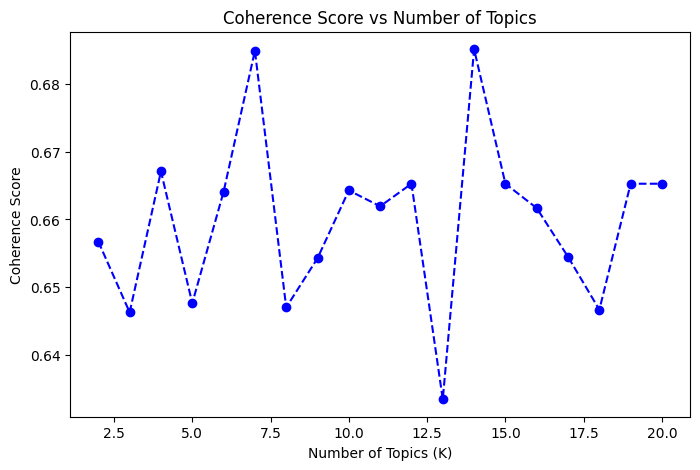

In [69]:
# plotting graph to find optimal k value for customized bert model
k_values, scores = zip(*coherence_scores)

plt.figure(figsize=(8,5))
plt.plot(k_values, scores, marker='o', linestyle='dashed', color='b')
plt.xlabel("Number of Topics (K)")
plt.ylabel("Coherence Score")
plt.title("Coherence Score vs Number of Topics")
plt.show()

In [72]:
# Using ideal number of topics for cutomized bert model
topic_model = BERTopic(embedding_model=custom_embed_model, verbose=True)
topics, probs = topic_model.fit_transform(texts, embeddings=embeddings, y=clusters)

# visualizing topics
topic_model.reduce_topics(tweets, nr_topics=7)
topic_model.visualize_barchart(n_words = 10, width = 300, height = 400)

2025-11-16 21:15:41,287 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-11-16 21:15:48,371 - BERTopic - Dimensionality - Completed ✓
2025-11-16 21:15:48,372 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-11-16 21:15:48,422 - BERTopic - Cluster - Completed ✓
2025-11-16 21:15:48,425 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-11-16 21:15:48,924 - BERTopic - Representation - Completed ✓
2025-11-16 21:15:49,338 - BERTopic - Topic reduction - Reducing number of topics
2025-11-16 21:15:49,348 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-11-16 21:15:49,939 - BERTopic - Representation - Completed ✓
2025-11-16 21:15:49,943 - BERTopic - Topic reduction - Reduced number of topics from 26 to 7


In [73]:
# Using ideal number of topics for base bert model
topic_model = BERTopic()
topics, probs = topic_model.fit_transform(texts)

# visualizing topics
topic_model.reduce_topics(texts, nr_topics=5)
topic_model.visualize_barchart(n_words = 10, width = 300, height = 400)

Base BERT
Topic 1: It has mix of things related to god and articles. So it could be related to bibles and cristianity.

Topic 2: Here it talks about team, space and some mixed topics.

Topic 3: Here there is a clear topic of sports , teams, season and others

Topic 4: Here it is related to health and what affects it like smoking etc.


Customized BERT
Topic 1: Here there is topic about education and god.

Topic 2: Here we can see that the topic is about games and team sports, as it has words such as game, players, season and so on..

Topic 3: Here there is no specific topic that we can point to.

## Extra Question (5 Points)

**Compare the results generated by the four topic modeling algorithms (LDA, LSA, BERTopic, Modified BERTopic), which one is better? You should explain the reasons in details.**

**This question will compensate for any points deducted in this exercise. Maximum marks for the exercise is 100 points.**

** *Ans. Among the four topic modeling algorithms LDA, LSA, BERTopic, and Modified BERTopic. Modified BERTopic performs the best overall due to its high coherence scores and excellent interpretability. While LDA offers a good balance of interpretability and performance using a probabilistic approach, it lacks the contextual understanding provided by transformer-based models. The number of topic provided by modified BERT is 3 and one can easily understand the topic by looking at top 10 words. whereas that not the case with other methods. LSA, being based on linear algebra (SVD), is fast but often produces overlapping and less coherent topics. BERTopic significantly improves topic quality by leveraging BERT embeddings and clustering techniques like HDBSCAN, capturing nuanced semantic relationships. The Modified BERTopic further enhances these strengths by incorporating advanced preprocessing, fine-tuned clustering parameters, and topic refinement, resulting in the most semantically meaningful and well-separated topics which makes it the most effective and versatile approach among the four.**

# Mandatory Question

**Important: Reflective Feedback on this exercise**

Please provide your thoughts and feedback on the exercises you completed in this assignment.

Consider the following points in your response:

**Learning Experience:** Describe your overall learning experience in working with text data and extracting features using various topic modeling algorithms. Did you understand these algorithms and did the implementations helped in grasping the nuances of feature extraction from text data.

**Challenges Encountered:** Were there specific difficulties in completing this exercise?

Relevance to Your Field of Study: How does this exercise relate to the field of NLP?

**(Your submission will not be graded if this question is left unanswered)**



In [ ]:
# Your answer here (no code for this question, write down your answer as detail as possible for the above questions):

'''
Please write you answer here:

This is one the best assignments so far. I have learnt a lot on topic modelling while doing this assignment.
The only problem i faced is while using GPT api, as it had lot of restrictions. It has limitations on tokens,
time and the number of calls. But, I overcame by using the opensource model, which i guess is inferior to gpt,
but has the same fundamental implmentation. I feel LSA and LDA were difficult to understand compared to BERT.
BERT was doing all the operations internally, but with LSA and LDA a lot tuning was required.
1 Thing i can confidently say is that i can now do topic modeling on any text.



'''